In [10]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# !ln -s ./drive/MyDrive/RossmanSalesPred/data/
# !ln -s ./drive/MyDrive/RossmanSalesPred/models/

# !ln -s ./drive/MyDrive/RossmanSalesPred/scripts/


In [12]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('scripts')))
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
sns.set()


In [14]:
from scripts.helper import Helper
import plots

In [15]:
helper = Helper()

In [9]:
train = helper.read_csv("./data/train.csv")
test = helper.read_csv("./data/test.csv")

file read as csv
file read as csv


In [16]:
display(train.head())
display(train.describe())
display(train.info())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


None

In [17]:
helper.percent_missing(train)

0.0

In [18]:
def get_feature(df):
  return df[["Date", "Sales"]]

In [19]:
def drop_closed(df):
  df = df[df['Open'] == 1]
  return df

In [20]:
def add_scaled_sales(df):
  scaled_sales = helper.scaler(df[["Sales"]], mode="minmax", columns=["scaled_sales"])
  df["scaled_sales"] = scaled_sales["scaled_sales"].to_list()
  return df

In [21]:
def handle_outliers(df, col, method="lower_upper"):
        
        df = df.copy()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        lower_bound = q1 - ((1.5) * (q3 - q1))
        upper_bound = q3 + ((1.5) * (q3 - q1))

        if method == "mean":
            df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

        elif  method == "mode":
            df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
        else:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

        return df

In [22]:
train["Sales"] = train["Sales"].astype("float")

In [23]:
data = drop_closed(train)
data = get_feature(data)
data = handle_outliers(data, "Sales")


In [24]:
data_agg = data.groupby("Date").agg({"Sales": "sum"})
helper.percent_missing(data_agg)
data_agg.describe()


,Sales
count,9.420000e+02
mean,6.131829e+06
std,3.040224e+06
min,9.357950e+04
25%,5.645826e+06
50%,6.521237e+06
75%,8.055236e+06
max,1.327816e+07


In [25]:
def check_stationary(df, col):
  adfResult = adfuller(df[col].values, autolag='AIC')
  print(f'ADF Statistic: {adfResult[0]}')
  print(f'p-value: {adfResult[1]}')
  return adfResult[1] >= 0.05

In [26]:
check_stationary(data_agg, "Sales")

ADF Statistic: -4.667799884472922
p-value: 9.668867829862378e-05


False

In [27]:
def corrPlots(array: np.array, title: str):
    plt.figure(figsize=(30, 5))
    plt.title(title)
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

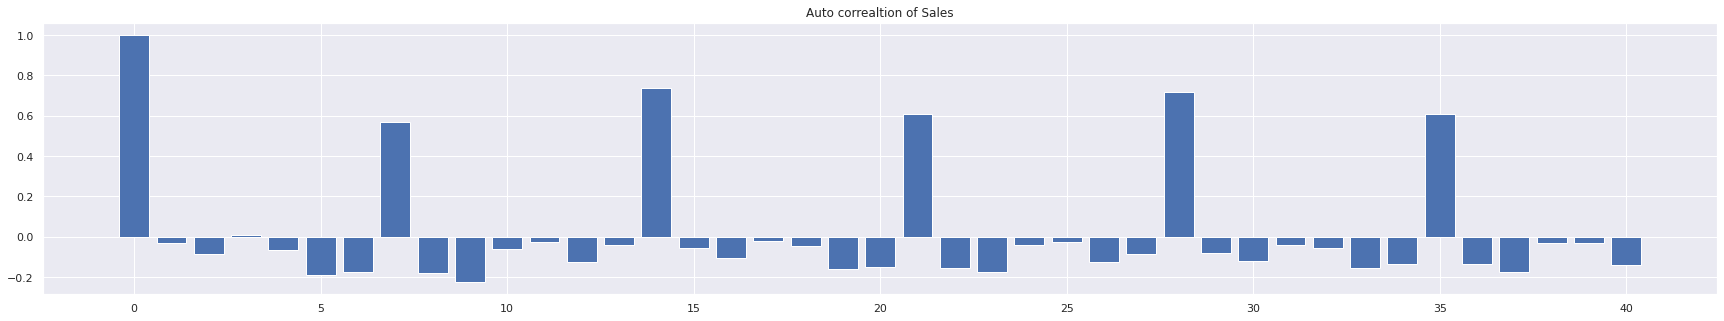

In [28]:
acfSalesScaled = acf(data_agg["Sales"].values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)
corrPlots(acfSalesScaledNp, 'Auto correaltion of Sales')

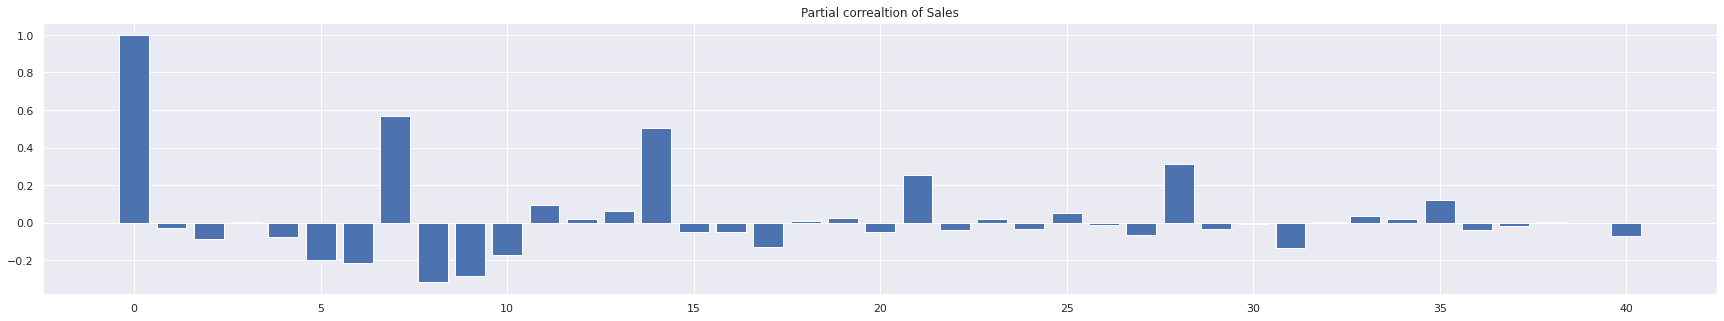

In [29]:
pacfSalesScaled = pacf(data_agg["Sales"].values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, 'Partial correaltion of Sales')

In [30]:
def windowed_dataset(series, window_size, batch_size): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [31]:
SIZE = len(data_agg["Sales"])
WINDOW_SIZE = 45
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 400

In [32]:
scaled_df = add_scaled_sales(data_agg)
data_agg["Sales"].isna().any().sum()



0

In [33]:
train_sales = scaled_df["scaled_sales"].values[0:BATCH_SIZE].astype('float32')
valid_sales = scaled_df["scaled_sales"].values[BATCH_SIZE:].astype('float32')
TrainDataset = windowed_dataset(train_sales, WINDOW_SIZE, BATCH_SIZE)
ValidDataset = windowed_dataset(valid_sales, WINDOW_SIZE, BATCH_SIZE)

In [34]:
model = Sequential()
model.add(LSTM(40, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(20, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 40)          6720      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 11,621
Trainable params: 11,621
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(TrainDataset, epochs=EPOCHS, validation_data=ValidDataset, verbose=1)

Epoch 1/400
1/1 [==============================] - 9s 9s/step - loss: 0.1589 - val_loss: 0.1635
Epoch 2/400
1/1 [==============================] - 0s 115ms/step - loss: 0.1417 - val_loss: 0.1449
Epoch 3/400
1/1 [==============================] - 0s 113ms/step - loss: 0.1256 - val_loss: 0.1274
Epoch 4/400
1/1 [==============================] - 0s 118ms/step - loss: 0.1106 - val_loss: 0.1109
Epoch 5/400
1/1 [==============================] - 0s 115ms/step - loss: 0.0965 - val_loss: 0.0955
Epoch 6/400
1/1 [==============================] - 0s 116ms/step - loss: 0.0834 - val_loss: 0.0810
Epoch 7/400
1/1 [==============================] - 0s 120ms/step - loss: 0.0712 - val_loss: 0.0674
Epoch 8/400
1/1 [==============================] - 0s 114ms/step - loss: 0.0598 - val_loss: 0.0550
Epoch 9/400
1/1 [==============================] - 0s 112ms/step - loss: 0.0495 - val_loss: 0.0440
Epoch 10/400
1/1 [==============================] - 0s 119ms/step - loss: 0.0406 - val_loss: 0.0349
Epoch 11/400

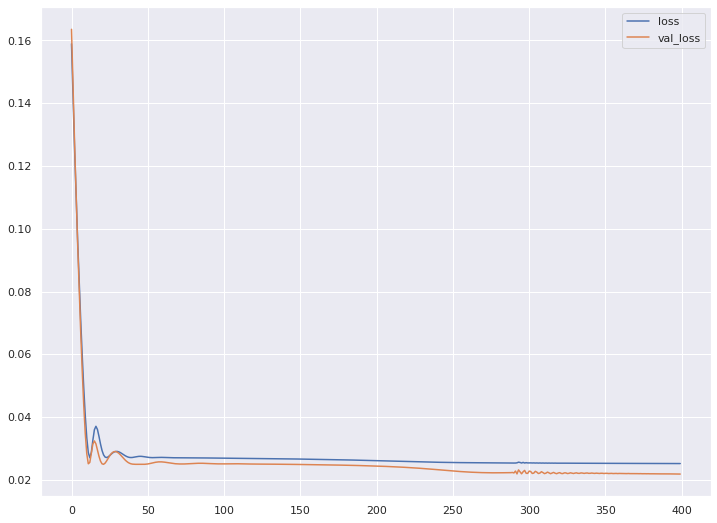

In [36]:
fig = plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [37]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [42]:
ValidDataset.reshape(-1, -1)

AttributeError: ignored

In [ ]:
def windowed_dataset(series, window_size, batch_size): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset